<a href="https://colab.research.google.com/github/ivanslootweg/ISMI/blob/sven/assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intelligent Systems in Medical Imaging 2023

This Jupyter notebook is part of the course Intelligent Systems in Medical Imaging (ISMI) from Radboud University (Nijmegen, Netherlands), and it was developed by researchers of Radboud University Medical Center (Nijmegen, Netherlands).

You should have obtained this notebook by downloading it from the official Brightspace page of the course.

This notebook formulates an assignment as part of the ISMI course, and the content of this notebook should be used solely to develop a solution to this assignment. You should not make the code provided in this notebook, or your own solution, publicly available.

## Teaching Assistants

* Bram de Wilde (bram.dewilde@radboudumc.nl)
* Pierpaolo Vendittelli (pierpaolo.vendittelli@radboudumc.nl)
* Joeran Bosma (joeran.bosma@radboudumc.nl)
* Stephan Dooper (stephan.dooper@radboudumc.nl)

For questions about the assignments that go beyond the content, you can contact Bram de Wilde. Questions about the content are addressed in the tutorial sessions. You are also encouraged to use the Brightspace discussion forums to discuss content of the assignments. We will also keep an eye out there to help!

## Guidelines and instructions
Make sure you write code in any place that says "YOUR CODE HERE" by substituting `None` variables or by adding your own solution. Make sure you write in any place that says "YOUR ANSWER HERE" with your answers to the questions.

Please **do not delete or add any cells**.

Before you turn this problem in, make sure everything runs without errors. The easiest way to check this is to restart the kernel and run all cells (in the menubar, select Runtime$\rightarrow$Restart & Run All).

* Groups: You should work in **groups of 2 or 3 people**. (groups of 2 are preferred!)
* You are expected to work in Google Colab. If you run the notebooks locally, you may have to solve some issues yourself!
* Submit your **fully executed** notebook to Brightspace with file name format: `GroupN_NameSurname1_NameSurname2_NameSurname3.ipynb`
* The deadlines for all assignments are on Brightspace.
* Deadlines are soft, but make an effort to be on time. We prioritise feedback on assignments that are handed in before the deadline.
* Each assignment has 100 points, your grade is your total number of points divided by 10.
* The assignments are mandatory, but **do not count** towards your final grade for the course.
* For assignments where you have to submit to grand-challenge.org, use team name format `ismi-GroupN-nickname1`.
* When working with Google Colab, we advise you to download model checkpoints (.h5 files). This way you don't lose your checkpoint if your session times out. Also, don't forget to connect to a **GPU runtime** when training neural networks!
* In Google Colab, you can mount your Google Drive to save files, by clicking the Folder icon on the left, and then click the Mount Drive icon.

There are more detailed instructions on Brightspace on how to use Google Colab for the assignments. You can find it here: https://brightspace.ru.nl/d2l/le/content/333312/Home

## Students
Please fill in this cell with your names, e-mail address and s-numbers. This information will be used to grade your assignment.

* [Ivan Slootweg], [s1001424], [ilse.slootweg@ru.nl]
* [Elina Antonova], [s1057069], [elina.antonova@ru.nl]
* [Sven van der Post], [s1028679], [sven.vanderpost@ru.nl]

--------
# Vessel segmentation in retina fundus images
<img src="https://github.com/ivanslootweg/ISMI/blob/elina/images/21_training.png?raw=1" width="250" height="250" align="right">

In this assignment we will return to the taks of segmentation of vessels in retina fundus images from assignment 2. This time however, we will solve the problem using deep learning. More specifically, we will explore different **fully convolutional neural networks** and **U-Net**.

## Data
For this assignment we will use data from the publicly available DRIVE dataset (http://www.isi.uu.nl/Research/Databases/DRIVE/).
The DRIVE dataset consists of 40 images, 20 used for training and 20 used for testing. Each case contains:
* a fundus (RGB) image
* a binary mask, which indicates the area of the image that has to be analyzed (removing black background)
* manual annotations of retinal vessels, provided as a binary map

## Imports
Let's get started by importing libraries needed for this assignment:

In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import shutil
import random
from random import randint
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import requests
from tqdm import tqdm_notebook 
import zipfile
import random
from tqdm import tnrange
from tqdm.notebook import tqdm
from pathlib import Path
from scipy.ndimage.interpolation import rotate

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # suppress all the TF informational-only messages

In [38]:
#Important to check that TensorFlow 2 is being used (pip freeze). If not: pip install --upgrade tensorflow
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow.keras.callbacks

overwrite=True #to reload already saved models

def print_installed():
    try:
        from pip._internal.operations import freeze
    except ImportError:  # pip < 10.0
        from pip.operations import freeze

    x = freeze.freeze()
    for p in x:
        print(p)
        
def print_tensorflow_version():
    print(f"Tensorflow v{tensorflow.__version__}")
    
print_tensorflow_version()

Tensorflow v2.11.0


## Download the data

In [39]:
# Script to download the dataset to your local computer
link = 'https://surfdrive.surf.nl/files/index.php/s/Kn4hCF4G919ijr3/download'
file_name = "DRIVE.zip"
if not os.path.isfile(file_name):
    with open(file_name, "wb") as f:
            response = requests.get(link, stream=True)
            total_length = response.headers.get('content-length')
            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                chunk_size = 4096
                for data in tqdm(response.iter_content(chunk_size=chunk_size), total=total_length//chunk_size, desc='Downloading data'):
                    dl += len(data)
                    f.write(data)
    with zipfile.ZipFile(file_name,"r") as zip_ref:
        zip_ref.extractall("./")
data_folder = 'DRIVE'

In [40]:
os.listdir('./DRIVE/training')

['1st_manual', 'mask', 'images']

------------
# Part 1: Fully convolutional neural networks
In previous assignments we've seen how neural networks can be applied to classify images into different categories. In this assignment we will explore how the same techniques can be applied to a segmentation task. For segmentation we conceptually solve the same taks as for classification: we can extract a patch around every pixel, and then classify the patch and assign the output back to the pixel location. As you can imagine, many classification steps have to be done to segment a full image: we will be working with images of size 584x565 (329960 pixels), so that would mean we have to apply 329960 classification steps to segment the full image.

However, when we move our patch by one pixel to classify the next pixel, a large proportion of the pixels of the new patch are identical to the previous patch, and we will be applying the same convolutions many times over. A trick to obtain a label for all pixels efficiently is to define a network architecture that does not include a fully connected (or dense) part. As the network only contains convolutional filters, the spatial structure is kept intact. Therefore the whole network can be thought of as a single large convolutional filter that can be applied to the whole image at once. This speeds up the classification and allows full image segmentation in milliseconds!

During training the same trick can be applied: use a full image as input, and train on all pixel-labels synchronously. In this assignment however, we will initially train the network on patches extracted from random locations in the training data.
There are several reasons why this could be useful. To name a few:
* In some applications you don't have a label for all pixels, so patches are a necessity.
* Less memory is needed during training, which may speed up training time dramatically.
* Per training iteration we can use patches from different source images, and apply augmentations on a patch-base, which increases diversity during training, leading to faster convergence and better results.
* We could design a sampling strategy so that regions of interests could be seen more often during training. It is also a way to control class balance during training.

## Tasks 
The tasks you have to perform in Part 1 of this assignment are:
1. Create a patch extractor and a batch creator to generate training data for the network.
2. Implement and train a fully convolutional neural network.
3. Use dilated convolutions.

## Create a training and validation set
We will load all training images into memory, and then divide them into two sets: one (called the **training set**) to optimize the weights of the network, and one (**validation set**) to monitor the performance of the network on unseen data.

In [41]:
def get_file_list(path, ext=''):
    return sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(ext)])

def load_img(path):
    return np.array(Image.open(path))

In [42]:
train_img_files = get_file_list(os.path.join(data_folder, 'training', 'images'), 'tif')
train_msk_files = get_file_list(os.path.join(data_folder, 'training', 'mask'), 'gif')
train_lbl_files = get_file_list(os.path.join(data_folder, 'training', '1st_manual'), 'gif')

train_imgs = [load_img(f) for f in train_img_files]
train_msks = [load_img(f) for f in train_msk_files]
train_lbls = [load_img(f) for f in train_lbl_files]

# we also load test image and masks, to be used later
test_img_files = get_file_list(os.path.join(data_folder, 'test', 'images'), 'tif')
test_msk_files = get_file_list(os.path.join(data_folder, 'test', 'mask'), 'gif')

test_imgs = [load_img(f) for f in test_img_files]
test_msks = [load_img(f) for f in test_msk_files]

print( "loading finished")

loading finished


Define how many images will be used for validation:

In [43]:
# Define the number of validation images here:
n_validation_imgs = None

n_validation_imgs = 2


In [44]:
"""DO NOT MODIFY THIS CELL"""

'DO NOT MODIFY THIS CELL'

Now we define a class ```DataSet``` that will be used to handle training and validation datasets:

In [45]:
class DataSet:
    
    def __init__(self, imgs, msks, lbls=None):
        self.imgs = imgs
        self.msks = msks
        self.lbls = lbls
    
    def show_image(self, i):
        if self.lbls != None:
            f, axes = plt.subplots(1, 3)
            for ax, im, t in zip(axes, 
                                 (self.imgs[i], self.msks[i], self.lbls[i]), 
                                 ('RGB image', 'Mask','Manual annotation')):
                ax.imshow(im, cmap='gray')
                ax.set_title(t)
        else:
            f, axes = plt.subplots(1, 2)
            for ax, im, t in zip(axes, 
                                 (self.imgs[i], self.msks[i]), 
                                 ('RGB image', 'Mask')):
                ax.imshow(im, cmap='gray')
                ax.set_title(t)
        plt.show()

In [46]:
# use the first images as validation
validation_data = DataSet(train_imgs[:n_validation_imgs], train_msks[:n_validation_imgs], train_lbls[:n_validation_imgs])

# the rest as training
train_data = DataSet(train_imgs[n_validation_imgs:], train_msks[n_validation_imgs:], train_lbls[n_validation_imgs:])

Let's inspect some of the loaded images:

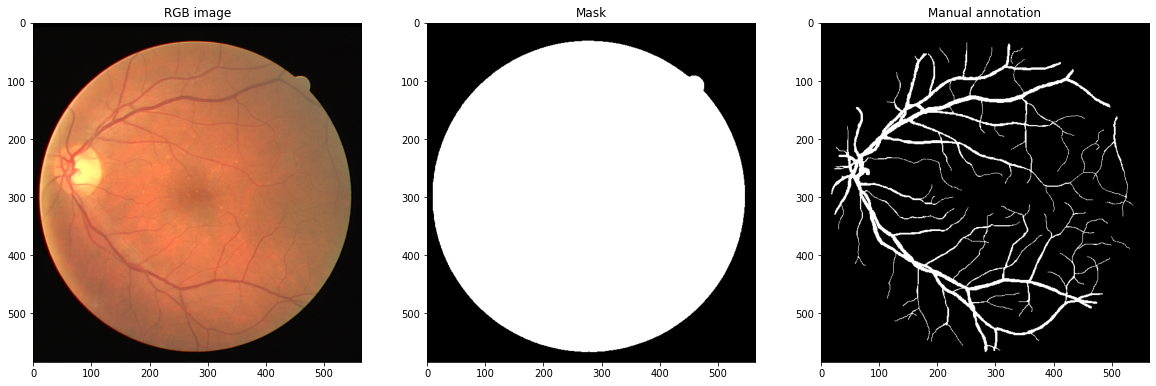

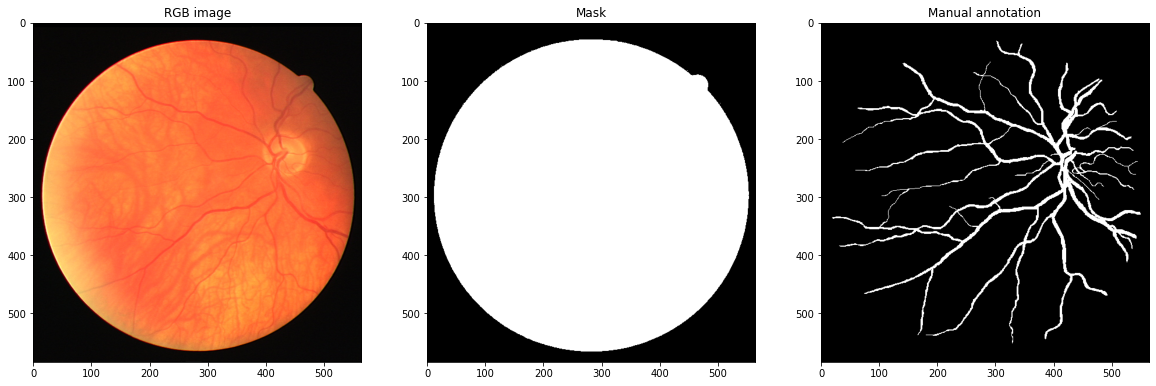

In [47]:
matplotlib.rcParams['figure.figsize'] = (20, 12)
validation_data.show_image(0) # change this parameter to try a few images
train_data.show_image(0) # change this parameter to try a few images

## Build a patch extractor

In this assignment we are going to implement a ```PatchExtractor``` class, which extract random patches from a list of images.
This means that you don't need to create a dataset beforehand and then use it to train you network, but you will just have a list of training images and annotation segmentations available, and patches will be extracted **on-the-fly** during training. For each example, you will need to generate an image patch and a corresponding label patch (patch with segmentation annotation) given a patch center location (y, x) and a predefined patch size (h, w). The generated image and label patches should have the same dimension.
This strategy allows to save time in the preparation of your *static* dataset, and allows the use of a *dynamic* generation of batches, where data augmentation can also be applied on-the-fly.

Note that this approach allows to test different strategies of data augmentation without the need for making a new dataset from scratch all the time. For now, we will only implement one kind of data augmentation in the ```get_patch``` method: **horizontal flipping**. The event will occur at random such that for each patch location, there is a 50% chance it gets flipped.

In [48]:
# Implement the get_patch method below:

class PatchExtractor:

    def __init__(self, patch_size, horizontal_flipping=True):
        self.patch_size = patch_size
        self.horizontal_flipping = horizontal_flipping
        
        
    def get_patch(self, image, mask, location):
        ''' 
        image: a numpy array representing the input image,
        mask: a numpy array representing the corresponding segmentation annotation
        location: a tuple with an y and x coordinate
        
        return a patch from the image at `location`, representing the center of the patch, and the corresponding label patch
        if self.horizontal_flipping = True, there is a 50% chance the patch is horizontally flipped  
        we will not rotate it or perform other augmentations for now to speed up the training process
        '''
        y, x = location
        py, px = self.patch_size
        
        # - patch should be a numpy array of size <h, w>
        # - the patch should be normalized (intensity values between 0-1)
        img_patch = None
        label_patch = None

        # YOUR CODE HERE
        ys = (y - int(py) / 2, y + int(py) / 2)
        xs = (x - int(px) / 2, x + int(px) / 2)
        
        img_patch = image[int(ys[0]):int(ys[1]),int(xs[0]):int(xs[1]),:]
        label_patch = mask[int(ys[0]):int(ys[1]),int(xs[0]):int(xs[1]),:]

        img_patch = (img_patch-np.min(img_patch))/(np.max(img_patch)-np.min(img_patch))
        img_patch_R, img_patch_G, img_patch_B  = img_patch[:, :, 0], img_patch[:, :, 1], img_patch[:, :, 2]

        epsilon = 0.00000001

        img_patch_R = (img_patch_R - np.min(img_patch_R)) / (np.max(img_patch_R) - np.min(img_patch_R) + epsilon)
        img_patch_G = (img_patch_G - np.min(img_patch_G)) / (np.max(img_patch_G) - np.min(img_patch_G) + epsilon)
        img_patch_B = (img_patch_B - np.min(img_patch_B)) / (np.max(img_patch_B) - np.min(img_patch_B) + epsilon)

        img_patch[:, :, 0] = img_patch_R
        img_patch[:, :, 1] = img_patch_G
        img_patch[:, :, 2] = img_patch_B
        
        # - if self.flipping = True, there should be a 50% chance to apply a horizontal flip to the patch  
        if self.horizontal_flipping:
            do_flipping = bool(random.getrandbits(1))
            
            # - if do_flipping == True, flip the patch horizontally
            if do_flipping:
                img_patch_flipped = img_patch[:, ::-1, :]
                label_patch_flipped = label_patch[:, ::-1, :]

                img_patch = img_patch_flipped
                label_patch = label_patch_flipped
        
        
        assert img_patch.ndim == label_patch.ndim
        return img_patch, label_patch


In [49]:
'''DO NOT MODIFY THIS CELL'''



'DO NOT MODIFY THIS CELL'

Let's test our patch extractor! By repeatedly executing the cell below, you should be able to see different augmentations of the same patch. The dot in the images represents the center of the patch, which is the pixel we are going to classify.

In [50]:
patch_size = (None, None) # Set the size of the patches as a tuple (height, width) 

img_index = None # choose an image to extract the patch from
location = (None, None) # define the location of the patch (y, x) - coordinate

# YOUR CODE HERE
patch_size = (20, 50) 

img_index = 15 # choose an image to extract the patch from
location = (220, 150) # define the location of the patch (y, x) - coordinate

In [51]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

Text(0.5, 1.0, 'mask at (220, 150)')

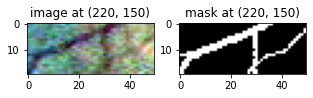

In [52]:
patch_extractor = PatchExtractor(patch_size, True)

matplotlib.rcParams['figure.figsize'] = (5, 5)
image_patch, label_patch = patch_extractor.get_patch(train_data.imgs[img_index], np.expand_dims(train_data.lbls[img_index], -1), location)
label_patch = np.repeat(label_patch, 3, axis=-1)
f, axes = plt.subplots(1, 2)
axes[0].imshow(image_patch)
axes[0].set_title('image at {}'.format(location))
axes[1].imshow(label_patch)
axes[1].set_title('mask at {}'.format(location))

## Build a batch creator

The BatchCreator will allow us to generate batches to train on. These batches contain a set of (class-balanced) samples or patches, and their corresponding labels. The data returned by the ```BatchCreator``` can directly be fed into the neural network for training or classification. 

First we define a useful function for padding images with a zero-border:

In [53]:
def pad(images, patch_size):
    '''
    images: list of images (numpy arrays)
    returns a padded version of the images, with a border of half the patch_size around each image
    '''
    half_py, half_px = [p//2 for p in patch_size]
    paddings = ((0, 0), (half_py, half_py), (half_px, half_px), (0, 0))
    return np.pad(np.array(images), pad_width=paddings, mode='constant') 

Now, implement the ```create_batch``` method in the ```BatchCreator``` class. It should return the patches and labels (```x_data``` and ```y_data```) where ```x_data``` denotes the image patch, and ```y_data``` is the corresponding labels. The idea is to predict whether a pixel is vessel or not by feeding the image patch surrounding the pixel to the network. So here the labels are the one-hot encoding class vectors for the pixels at the patch center. Previously, you have implemented a patch extractor that gives you an image and label patch. You should be able to compute the pixel labels at patch center from the label patch.
We also provide you an implementation of a class balanced patch location sampler, which will compute locations to extract patches such that half of the locations are foreground pixels (vessels) and the other half of the locations are background pixels (inside the fundus mask, but not vessels).  

In [54]:
class BalancedSampler:

    def __init__(self, lbls, msks):
        # pre calculate the positive and negative indices
        lbls = np.squeeze(lbls, 3)
        msks = np.squeeze(msks, 3)
        self.p_idxs = np.asarray(np.where(lbls > 0)).T.tolist()
        self.n_idxs = np.asarray(np.where((msks > 0) & ~(lbls > 0))).T.tolist()

    def generate_sample_locations(self, batch_size):
        # generate locations half from the positive set and half from the negative set
        p_locations = random.sample(self.p_idxs, batch_size // 2)
        n_locations = random.sample(self.n_idxs, batch_size - batch_size // 2)
        locations = np.vstack([p_locations, n_locations])
        return locations

In [55]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset, border_pad_size):
        self.patch_extractor = patch_extractor

        # the images are padded with half the patch-size around the border
        # this way, we don't risk extracting patches from the border, that extend beyond the original image
        self.imgs = pad(dataset.imgs, border_pad_size)
        self.lbls = pad(np.expand_dims(dataset.lbls, 3), border_pad_size)
        self.msks = pad(np.expand_dims(dataset.msks, 3), border_pad_size)
        self.patch_location_sampler = BalancedSampler(self.lbls, self.msks)

    def create_batch(self, batch_size):
        '''
        returns a class-balanced array of patches (x) with corresponding labels (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 3))
        y_data = np.zeros((batch_size, 1, 1, 2))  # one-hot encoding
        locations = self.patch_location_sampler.generate_sample_locations(batch_size)
        
        # YOUR CODE HERE
        for loc in range(len(locations)):
            xy_loc = locations[loc][1:]
            x_data[loc], _ =  patch_extractor.get_patch(self.imgs[locations[loc][0]], self.lbls[locations[loc][0]], xy_loc)
            label = [1,0] if self.lbls[locations[loc][0]][xy_loc[0],xy_loc[1]][0] == 255 else [0,1]
            y_data[loc] = [[label]]
      
        return x_data, y_data
        
    def get_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch(batch_size)


In [56]:
'''DO NOT MODIFY THIS CELL'''


'DO NOT MODIFY THIS CELL'

Let's test our BatchCreator! Half of the patches in the visualization below should represent vessel patches (having a vessel in the center of the patch). The other half should represent background patches (no vessel in the center of the patch). The dot in the images represents the center of the patch, which is the pixel we are going to classify.

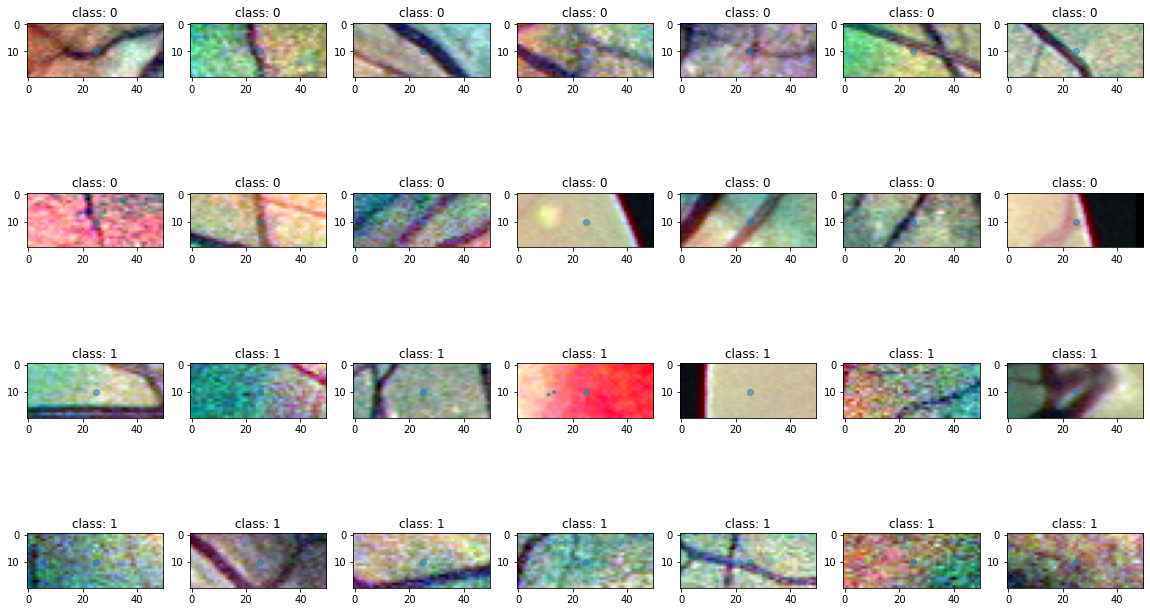

In [57]:
batch_creator = BatchCreator(patch_extractor, train_data, patch_extractor.patch_size)

# create a batch
x, y = batch_creator.create_batch(28)
# visualize it
matplotlib.rcParams['figure.figsize'] = (20, 12)
f, axes = plt.subplots(4, 7)
i = 0;
for ax_row in axes:
    for ax in ax_row:
        ax.imshow(x[i])
        ax.set_title('class: {}'.format(np.argmax(y[i, 0, 0])))
        # NB: I have added code to reverse array, because patch size has height as first argument and width as second, 
        # while they do not correspond to x and y exis, since x is always coming first.
        ax.scatter(*[p/2 for p in patch_extractor.patch_size[::-1]], alpha=0.5)
        i += 1
plt.show()

## Build and train the first fully convolutional network

We will now start with defining our initial network architecture in Keras.

This is another package to do deep learning package in python, a popular alternative to PyTorch. Here is a short example of how you define a simple network with Keras:
```python
from keras import layers

inputs = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=predictions)
model.compile(...)
```
For more information, check out https://keras.io/guides/functional_api/

What is important to train a fully convolutional neural network on patches, is that **the size of the feature maps within the network goes down to exactly 1x1 for the final feature map**. 
We will therefore use **valid** convolutions (in contrast to **same** convolutions) and pooling operations to reduce the size of the feature maps.
This requires some computation, but luckily it is pretty straightforward:  

If we define:
```
i = Input featuremap size
o = Output featuremap size 
f = Convolution filter size 
m = Pooling size
```
Then:

Output size of a feature map after convolution with a convolution filter of size f:
```python
o = i - (f - 1)
```
Output size of a feature map after pooling of size m:
```python
o = floor(i/m)
```

### Model definition
Let's define a baseline model:
* input layer 
* 32 filters of 4x4
* 32 filters of 3x3
* pooling
* 64 filters of 3x3
* 64 filters of 3x3
* pooling
* 128 filters of 3x3
* 64 filters of 1x1
* 2 filters of 1x1 

After every convolution we will apply a **relu** non-linearity. The last layer should have a **softmax** non-linearity to transform the 2 filters in probabilities for the vessel and background class.  

The reason to start with the less common 4x4 convolutions, is that we wish to define a patch-size that has an odd number of pixels (so that we can define a single center pixel that corresponds with the label). At the same time, we want the input to the pooling layers to be even, so we don't exclude the pixels around the border. The 1x1 convolutions in the deeper layers act as the dense part of a classification network: we no longer take contextual information into account, but only do recombination of features. The final two filters represent the two classes background and vessel.

**NOTE**: Since a fully-convolutional network can process input patches of (almost) any size, we should not hard-code a specific size in the ```Input``` layer. The way of doing this is to define the height and the width of input patches as ```None```. The same trick is used to avoid specifying a mini-batch size, which can be changed arbitrarily. We do hard-code the presence of 3 channels, because we are going to process RGB images.

In [58]:
## DEFINE THE ABOVE DESCRIBED MODEL HERE
x_in = Input(batch_shape=(None, None, None, 3)) # DO NOT REPLACE None HERE! It is actually needed!!!


x_out = None # this is the output fo your network, used later on in this notebook

# input shape is (32x32x3)

# YOUR CODE HERE
x = Conv2D(32, (4,4), activation="relu")(x_in)
x = Conv2D(32, (3,3), activation="relu")(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation="relu")(x)
x = Conv2D(64, (3,3), activation="relu")(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = Conv2D(64, (1,1), activation="relu")(x)
x_out = Conv2D(2, (1,1), activation="softmax")(x)

In [59]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

## Define the loss, compile the model and define the logging

For this assignment we will use the cross-entropy loss (sometimes also referred to as log-loss). In this case it is equivalent to the mean log of the differences between true labels and the predicted labels for a given batch.

In [60]:
model_1 = Model(x_in, x_out)
print(model_1.summary())
# define the optimizer. etc
learning_rate = 1e-4
optimizer = Adam(learning_rate)
model_1.compile(optimizer, loss='categorical_crossentropy')


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 32)    1568      
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 32)    9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 64)    36928     
                                                           

Here we define a logger class, that will store useful data througout the training procedure:

In [61]:
def downscale(images, stride):
    # Downscale if the network does pooling
    return np.array(images)[:, ::stride, ::stride]

def calculate_dice(x, y):
    '''returns the dice similarity score, between two boolean arrays'''
    return 2 * np.count_nonzero(x & y) / (np.count_nonzero(x) + np.count_nonzero(y))
    
class Logger(tensorflow.keras.callbacks.Callback):

    def __init__(self, validation_data, patch_size, stride=1):
        self.val_imgs = pad(validation_data.imgs, patch_size) / 255.
        self.val_lbls = downscale(validation_data.lbls, stride) > 0
        self.val_msks = downscale(validation_data.msks, stride) > 0
         
        self.losses = []
        self.dices = []
        self.best_dice = 0
        self.best_model = None
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    
    def on_epoch_end(self, batch, logs={}):
        dice = self.validate()
        self.dices.append([len(self.losses), dice])
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_model = self.model.get_weights()
        self.plot()
           
    def validate(self):
        predicted_lbls = self.model.predict(self.val_imgs, batch_size=1)[:,:,:,1]>0.5
        x = self.val_lbls[self.val_msks]
        y = predicted_lbls[self.val_msks]
        return calculate_dice(x, y)
    
    def plot(self):
        clear_output()
        N = len(self.losses)
        train_loss_plt, = plt.plot(range(0, N), self.losses)
        dice_plt, = plt.plot(*np.array(self.dices).T)
        plt.legend((train_loss_plt, dice_plt), 
                   ('training loss', 'validation dice'))
        plt.show()

Now you have to define some parameters, which are needed to train your network.
To do validation during training, we need to define the downscaling factor (which we call ```stride```) due to pooling of our network. That is: how much lower is the resolution of the output compared to the input?

In [98]:
patch_size = (None, None)       # should be a tuple of width, height corresponding to your network architecture 
batch_size = None               # pick a reasonable batch-size (e.g. power-of-two in the range 32, 64, 128, 256)

# To let the network converge to a reasonable state, steps_per_epoch * epochs should be around 5000 to 10000

steps_per_epoch = None         # how many steps per epoch?
epochs = None                  # how many epochs? 
stride = None                  # what is the downscaling factor of your network?
# YOUR CODE HERE
patch_size = (25, 25)
batch_size = 64
steps_per_epoch = 50
epochs = 100
stride = 4

flipping = True

In [99]:
'''DO NOT MODIFY THIS CELL'''


'DO NOT MODIFY THIS CELL'

What is the correct value for our downsampling factor (stride) and why?

YOUR ANSWER HERE

Now we use all the classes defined so far to initialize data that will be used for training and validation.

In [100]:
patch_extractor = PatchExtractor(patch_size, horizontal_flipping=True)
batch_creator = BatchCreator(patch_extractor, train_data, patch_size)
generator = batch_creator.get_generator(batch_size)
logger_1 = Logger(validation_data, patch_size, stride=stride)

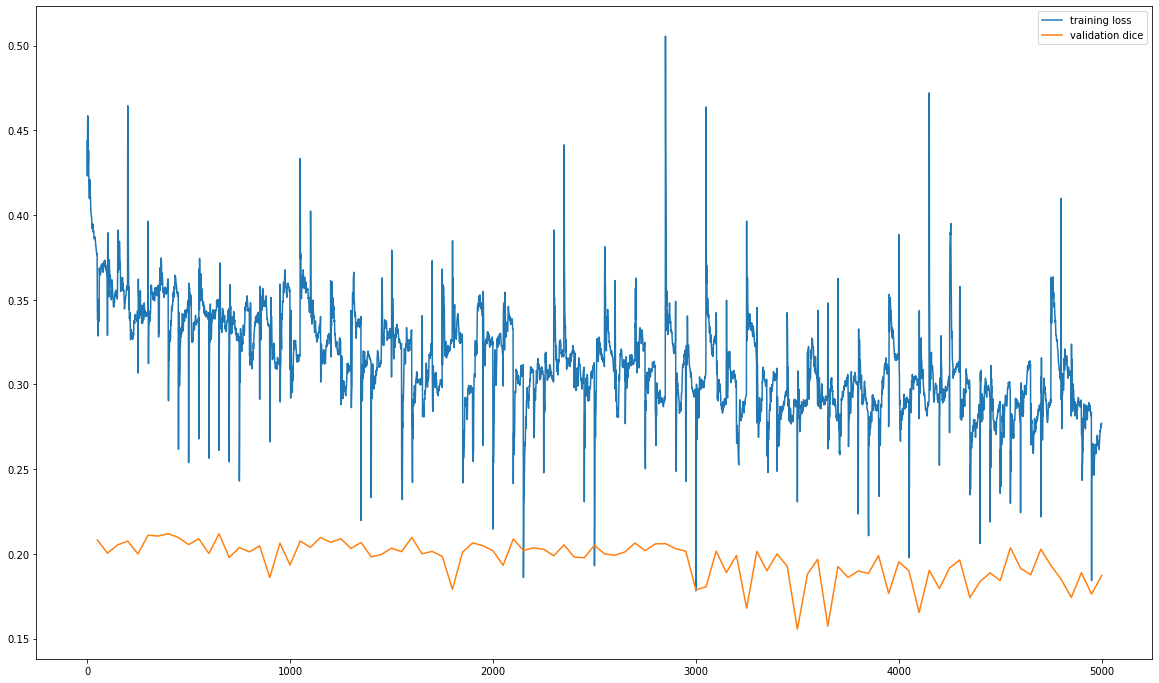

50/50 [==============================] - 1s 22ms/step - loss: 0.2770


In [101]:
if overwrite or not Path('./model_1').exists():
    model_1.fit_generator(generator=generator, 
                      steps_per_epoch=steps_per_epoch, 
                      epochs=epochs, 
                      callbacks=[logger_1])

## Check results on the validation set

Now let's apply the trained model to the validation data to get an idea how well the network is performing. We will define the function ```process_basic``` below to apply the model to a dataset. 

In [102]:
def process_basic(model, dataset, stride=1):
    
    # pad the original images, so we don't loose the borders in our output
    imgs = pad(dataset.imgs, patch_size) / 255.
    
    # downscale the label and masks if needed (to get the same resolution as the output)
    lbls = downscale(dataset.lbls, stride) > 0
    msks = downscale(dataset.msks, stride) > 0
    
    # apply our model to the images
    output = model.predict(imgs, batch_size=1)[:,:,:,1]

    return lbls, msks, output

We will use the following function to visually inspect the results and calculate a dice-score for each image:

In [103]:
def check_results(imgs, lbls, msks, output, threshold=0.5):

    dices = []
    for i, (img, lbl, msk, raw_output) in enumerate(zip(imgs, lbls, msks, output)):
        
        final_output = raw_output > threshold
        
        dice = calculate_dice(final_output[msk], lbl[msk])
        dices.append(dice)
        print('image:', i, 'dice', dice)
        
        # plot the results
        matplotlib.rcParams['figure.figsize'] = (15, 6)
        f, axes = plt.subplots(1, 4)
        for ax, im, t in zip(axes, 
                             (img, raw_output, final_output, lbl), 
                             ('RGB image', 'Soft prediction', 'Thresholded', 'Ground truth')):
            ax.imshow(im, cmap='gray')
            ax.set_title(t)
        plt.show()
        
    print('mean dice', np.mean(dices))

Now we load the best model (based on the validation dice score during training), and check the results:

2/2 [==============================] - 0s 16ms/step
image: 0 dice 0.19131327388208122


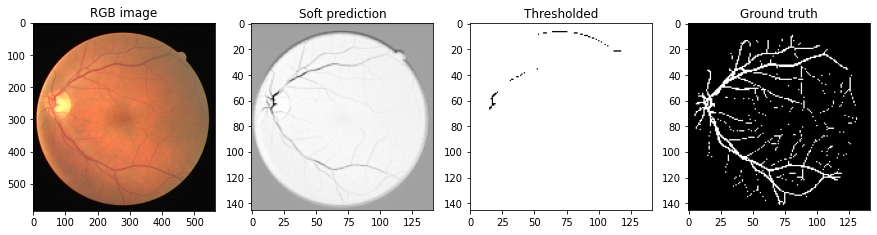

image: 1 dice 0.2317921948794432


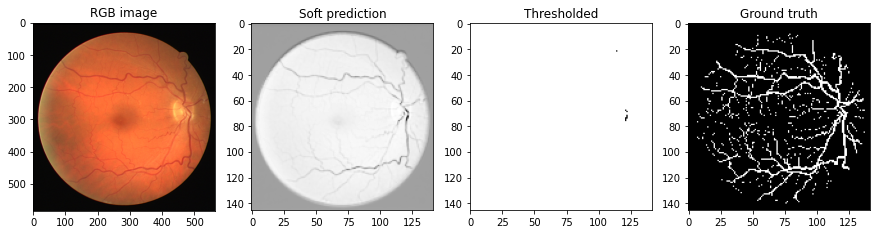

mean dice 0.21155273438076222


In [104]:
#model_1.load('./model_1')
if overwrite or not Path('./model_1').exists():
    model_1.set_weights(logger_1.best_model)
    model_1.save('./model_1')
else:
    model_1 = load_model('./model_1')

lbls, msks, output =  process_basic(model_1, validation_data, stride=stride)
check_results(validation_data.imgs, lbls, msks, output, threshold=0.5)

## Use dilated convolutions

<img align="right" width="300" src="https://github.com/ivanslootweg/ISMI/blob/elina/images/dilation.gif?raw=1">

You can see that the label image predicted by our network has a **much lower resolution** then the input image.
This is due to the pooling operations that we used in our network. One solution to this would be to completely remove the pooling layers. For this, however, we would need to train using even smaller patches as input, reducing the context even more.

To get state-of-the-art results, it is normally necessary to include a **larger context**. If we wish to do this without introducing pooling operations or increasing the complexity of the network too much, we have another option: dilated convolutions.

Dilated convolutions work like regular convolutions, but introduce a spacing between the parameters of the filter. This way, they expand the area covered by the filter (often referred to as the **receptive field**). Unlike pooling operations, they do not reduce the resolution of the feature maps. Let's experiment with them, and define a new network architecture that includes dilated convolutions. See the image to the right for an example of a 3x3 convolution filter with dilation rate 2 (image taken from https://github.com/vdumoulin/conv_arithmetic ).

Implement the following network
* input layer 
* 32 filters of 3x3
* 32 filters of 3x3
* 64 filters of 3x3, dilation rate 2
* 64 filters of 3x3, dilation rate 4
* 128 filters of 3x3, dilation rate 8
* 64 filters of 1x1
* 2 filters of 1x1 

Note:
1. kernel weights initializer should be `'he_uniform'`
2. activation (except for final softmax) should be `'relu'`

In [117]:
x_in = Input(batch_shape=(None, None, None, 3))
x_out = None
# YOUR CODE HERE

from tensorflow.keras.initializers import HeUniform

initializer = HeUniform()

x = Conv2D(32, (3,3), activation="relu", kernel_initializer=initializer)(x_in)
x = Conv2D(32, (3,3), activation="relu")(x)
x = Conv2D(64, (3,3), activation="relu", dilation_rate=2)(x)
x = Conv2D(64, (3,3), activation="relu", dilation_rate=4)(x)
x = Conv2D(128, (3,3), activation="relu", dilation_rate=8)(x)
x = Conv2D(64, (1,1), activation="relu")(x)
x_out = Conv2D(2, (1,1), activation="softmax")(x)

In [106]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

In [118]:
model_2 = Model(x_in, x_out)
model_2.compile(optimizer, loss='categorical_crossentropy')


Set the new patch_size and stride for this network:

In [120]:
patch_size = None
stride = None
# YOUR CODE HERE

patch_size = (25,25) 
stride = 4

In [121]:
'''DO NOT MODIFY THIS CELL'''

'DO NOT MODIFY THIS CELL'

In [122]:
patch_extractor = PatchExtractor(patch_size, horizontal_flipping=True)
batch_creator = BatchCreator(patch_extractor, train_data, patch_size)

patch_generator = batch_creator.get_generator(batch_size)

logger_2 = Logger(validation_data, patch_size, stride=stride)

In [123]:
if overwrite or not Path('./model_2').exists():
    model_2.fit_generator(generator=patch_generator, 
                      steps_per_epoch=steps_per_epoch, 
                      epochs=epochs, 
                      callbacks=[logger_2])

Epoch 1/100


<ipython-input-123-aee32eb461ee>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_2.fit_generator(generator=patch_generator,


StagingError: ignored

Again, we will load the best model (the one that achieved highest Dice score during training) and inspect the results on the validation set:

In [ ]:
if overwrite or not Path('./model_2').exists():
    model_2.set_weights(logger_2.best_model)
    model_2.save('./model_2')
else:
    print('loading saved model')
    model_2 = load_model('./model_2')
lbls, msks, output = process_basic(model_2, validation_data)
check_results(validation_data.imgs, lbls, msks, output, threshold=0.5)


## Submit test results to grand-challenge

Now you can process images in the test set and submit your results to grand-challenge.
You can tune the threshold and (optionally) apply the mask before submission.

In [ ]:
# define output folder
result_output_folder = './results'
if not os.path.exists(result_output_folder):
    os.makedirs(result_output_folder)

# threshold to select segmented pixels
threshold = 0.5

# pad all images in the test set
imgs = pad(test_imgs, patch_size) / 255.
   
# apply our model to the images
output = model_2.predict(imgs, batch_size=1)[:,:,:,1]

# save all output masks as png images
for i in range(output.shape[0]):

    # output has to be:
    # - thresholded
    # - converted to grayscale
    segmentation = 255 * (output[i, :, :].squeeze() > threshold).astype(int)
    
    # save to disk
    im = Image.fromarray(segmentation.astype('uint8'))
    im.save(os.path.join(result_output_folder, "{}.png".format(i + 1)))

In [ ]:
shutil.make_archive('results', 'zip', result_output_folder)

------------
# Part 2: U-Net

As you might have observed, the use of dilated convolutions in the fully-convoutional network gives a full-resolution output, but the processing is slow due to the large feature maps. In the second part of this assignment, we are going to work with **U-Net** for retina vessels segmentation.

## Tasks
These are the main tasks of the second part of this assignment:
1. Implement a batch creator that generates image and label patches for U-Net training.
2. Train a baseline U-Net model.
3. Improve the U-Net implementation to increase performance.

## Implement a batch creator that generates image and mask patches for U-Net training

We implement here the ``UNetBatchCreator``. Note that our previous model predicted a label for the center pixel, given the surrounding image patch. Now the U-Net model will predict labels for all pixels in a patch. Therefore, you need to implement a batch creator to generate batches of image patches and the correspoding whole segmentation annotation patches. For simplicity, this creator makes use of the previous  ``BalancedSampler``, although it is not relevant anymore that center pixels of the patches belong to positive or negative samples in a balanced way.

In [ ]:
class UNetBatchCreator(BatchCreator):

    def __init__(self, patch_extractor, dataset, border_pad_size):
        super(UNetBatchCreator, self).__init__(patch_extractor, dataset,
                                                    border_pad_size)

        self.patch_location_sampler = BalancedSampler(self.lbls, self.msks)
    
    def create_batch(self, batch_size):
        '''
        returns a batch of image patches (x) with corresponding label patches (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 3))
        y_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 2))  # one-hot encoding

        locations = self.patch_location_sampler.generate_sample_locations(batch_size)

        # YOUR CODE HERE
        
        return x_data, y_data

In [ ]:
'''DO NOT MODIFY THIS CELL'''

## Implement and train a baseline U-Net model

Here we explicitly define a baseline U-Net model. It has a depth of 4 (3 pooling layers), it uses 'same' convolutions and it starts with 16 filters in the first layer. We will still use patch-based training for U-Net. We have defined the input to the network to be an image patch of size 88x88 (you could also try with other patch sizes). Let's call it ``unet_1``.

In [ ]:
def build_unet_1(printmodel=True):
    
    inputs = Input(shape=(None, None, 3))

    # First conv pool
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    # Second conv pool
    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Third conv pool
    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # Fourth conv pool
    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    # First up-conv
    u2 = UpSampling2D()(c4)
    m2 = concatenate([c3, u2])
    cm2 = Conv2D(64, 3, activation='relu', padding='same')(m2)
    cm2 = Conv2D(64, 3, activation='relu', padding='same')(cm2)

    # Third up-conv
    u3 = UpSampling2D()(cm2)
    m3 = concatenate([c2, u3])
    cm3 = Conv2D(32, 3, activation='relu', padding='same')(m3)
    cm3 = Conv2D(32, 3, activation='relu', padding='same')(cm3)

    # Fourth up-conv
    u4 = UpSampling2D()(cm3)
    m4 = concatenate([c1, u4])
    cm4 = Conv2D(16, 3, activation='relu', padding='same')(m4)
    cm4 = Conv2D(16, 3, activation='relu', padding='same')(cm4)

    # Output
    predictions = Conv2D(2, 1, activation='softmax')(cm4)

    model = Model(inputs, predictions)
    
    if printmodel:
        print(model.summary())
    
    return model

Make an instance of the ``unet_1`` model:

In [ ]:
unet_1 = build_unet_1()

learning_rate = 1e-4
optimizer = Adam(learning_rate)

unet_1.compile(optimizer, loss='categorical_crossentropy')

Initialize all training parameters, define an image generator that will be able to return mini-batches during the training procedure, define a loss function, the mini-batch size, and other parameters needed to train U-Net. Replace ``None`` with some values.

In [ ]:
patch_size = (None, None)
batch_size = None
steps_per_epoch = 100
epochs = None
# YOUR CODE HERE

In [ ]:
'''DO NOT MODIFY THIS CELL'''

We also provide you a ``UNetLogger`` class. Note that during validation, we do not pad image borders with half the patch size with 0s as before. Because we use same padding for U-Net, the output should have the same size as the input. But there is an exception where the input size cannot be divisable by the maximum downsampling rate (in our baseline U-Net, it is 8 (three poolings and each of them divides the size by 2)). To force the output and input to have the same size, we pad the input to a shape that is divisable by 8, implemented by the ``pad_ensure_division`` function.  Check the ``validation`` function and compare with the ``Logger`` class.

In [ ]:
def pad_ensure_division(h, w, division):

    def compute_pad(s, d):
        if s % d != 0:
            p = 0
            while True:
                if (s + p) % d == 0:
                    return p
                p += 1
        return 0

    py = compute_pad(h, division)
    px = compute_pad(w, division)
    padding = (py//2, py-py//2), (px//2, px-px//2)
    return padding


class UNetLogger(tensorflow.keras.callbacks.Callback):

    def __init__(self, validation_data):
        self.val_imgs = np.asarray(validation_data.imgs) / 255.
        self.val_lbls = np.asarray(validation_data.lbls) > 0
        self.val_msks = np.asarray(validation_data.msks) > 0

        self.losses = []
        self.dices = []
        self.best_dice = -1
        self.best_model = None

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, batch, logs={}):
        dice = self.validate()
        self.dices.append([len(self.losses), dice])
        if dice > self.best_dice:
            print('updating the best model')
            self.best_dice = dice
            self.best_model = self.model.get_weights()
        self.plot()

    def validate(self):
        # need to pad image such that the size can be divisable by 8
        h, w = self.val_imgs.shape[1:3]
        (py0, py1), (px0, px1) = pad_ensure_division(h, w, 8)
        padding = ((0, 0), (py0, py1), (px0, px1), (0, 0))
        pad_val_imgs = np.pad(self.val_imgs, pad_width=padding, mode='constant')

        # run unet model
        predicted_lbls = np.argmax(self.model.predict(pad_val_imgs, batch_size=1), axis=-1)
        
        # crop it back because we pad it before
        b, h, w = predicted_lbls.shape
        predicted_lbls = predicted_lbls[:, py0:h-py1, px0:w-px1]

        x = self.val_lbls[self.val_msks]
        y = predicted_lbls[self.val_msks]
        
        return calculate_dice(x, y)

    def plot(self):
        clear_output()
        N = len(self.losses)
        train_loss_plt, = plt.plot(range(0, N), self.losses)
        dice_plt, = plt.plot(*np.array(self.dices).T)
        plt.legend((train_loss_plt, dice_plt),
                   ('training loss', 'validation dice'))
        plt.show()

In [ ]:
patch_extractor = PatchExtractor(patch_size, horizontal_flipping=True)
batch_creator = UNetBatchCreator(patch_extractor, train_data, patch_size)
patch_generator = batch_creator.get_generator(batch_size)

logger_3 = UNetLogger(validation_data)

Now we train the model:

In [ ]:
if overwrite or not Path('./unet_1').exists():
    unet_1.fit_generator(generator=patch_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=epochs, callbacks=[logger_3])

We also need to change the ``process_basic`` function a bit in order to process one image using U-Net. Remember you need to pad the image when its size cannot be divided by the total downsampling rate in your U-Net (in our baseline U-Net it is 8). This ensures that the output size and the input size of the U-Net model are always the same. 

In [ ]:
def process_unet(model, imgs):
    # pad image if the size is not divisable by total downsampling rate in your U-Net 
    # YOUR CODE HERE
    
    # run unet model
    output = model.predict(pad_imgs, batch_size=1)[:, :, :, 1]
    
    # don't forget to crop it back because you pad it before.
    # YOUR CODE HERE

    return lbls, msks, output

In [ ]:
""" DO NOT MODIFY THIS CELL"""

Now we run the best model on the validation images:

In [ ]:
def check_results_unet(imgs, lbls, msks, output, threshold=0.5):

    dices = []
    for i, (img, lbl, msk, raw_output) in enumerate(zip(imgs, lbls, msks, output)):
        final_output = raw_output > threshold
        
#         print('Output_mask: {}\nLbl: {}'.format(final_output[3].shape, lbl.shape))
        dice = calculate_dice(final_output[i], lbls[i])
        dices.append(dice)
        print('image:', i, 'dice', dice)
        
        # plot the results
        matplotlib.rcParams['figure.figsize'] = (15, 6)
        f, axes = plt.subplots(1, 4)
        for ax, im, t in zip(axes, 
                             (img, raw_output[i], final_output[i], lbl), 
                             ('RGB image', 'Soft prediction', 'Thresholded', 'Ground truth')):
            ax.imshow(im, cmap='gray')
            ax.set_title(t)
        plt.show()
        
    print('mean dice', np.mean(dices))

In [ ]:
if overwrite or not Path('./unet_1').exists():
    unet_1.set_weights(logger_3.best_model)
    unet_1.save('./unet_1')
else:
    print('loading saved unet_1')
    unet_1 = load_model('./unet_1')
    
imgs = np.asarray(validation_data.imgs) / 255.
lbls = np.asarray(validation_data.lbls) > 0
msks = np.asarray(validation_data.msks) > 0
output = process_unet(unet_1, imgs)
# print((validation_data.lbls[3].shape))

check_results_unet(validation_data.imgs, lbls, msks, output, threshold=0.5)

## Improve the U-Net implementation to increase performance

You have realized that this baseline model does not perform well. Now, it is time to boost performance. These are different ideas:
- You can adjust the different training hyperparameters (learning rate, mini-batch size, etc.).
- You can change the number of filters per layer by passing a different input parameter ``initial_filters`` (default = 16) to ``build_unet_2()``, and experiment the effect of using a wider U-Net model.
- You can make use of different techniques seen during the lessons (batch normalization, dropout, etc).
- You can add class weights in your loss function for balancing positive and negative classses (last optional task).


Additionally, a U-Net model can be built by writing a simple program, because U-Net blocks have all the same structure, which can be coded as a function. Here we implement U-Net blocks, which will make the design of more U-Net architectures in this assignment much easier.

In [ ]:
# Create a function that builds a U-Net block, containing conv->(batchnorm->dropout->)conv->(batchnorm->dropout),
# where batchnorm and dropout are optional and can be selected via input parameters.
# The function returns the output of the block layers.
def unet_block(inputs, n_filters, batchnorm=False, dropout=False):
    
    # YOUR CODE HERE
    
    return cl

In [ ]:
""" DO NOT MODIFY THIS CELL """

Use ``unet_block()`` to build a U-Net model with a script: 

In [ ]:
def build_unet_2(initial_filters=16, n_classes=2, batchnorm=False, dropout=False, printmodel=False):

    # build U-Net again using unet_block function
    inputs = Input(shape=(None, None, 3)) #adjust

    # CONTRACTION PART

    # First conv pool
    c1 = unet_block(inputs, initial_filters, batchnorm, dropout)
    p1 = MaxPooling2D()(c1)

    # Second conv pool
    c2 = unet_block(p1, 2*initial_filters, batchnorm, dropout)
    p2 = MaxPooling2D()(c2)

    # Third conv pool
    c3 = unet_block(p2, 4*initial_filters, batchnorm, dropout)
    p3 = MaxPooling2D()(c3)

    # Fourth conv
    c4 = unet_block(p3, 8*initial_filters, batchnorm, dropout)

    # EXPANSION PART

    # First up-conv
    u2 = UpSampling2D()(c4)
    m2 = concatenate([c3, u2])
    cm2 = unet_block(m2, 4*initial_filters, batchnorm, dropout)

    # Second up-conv
    u3 = UpSampling2D()(cm2)
    m3 = concatenate([c2, u3])
    cm3 = unet_block(m3, 2*initial_filters, batchnorm, dropout)

    # Third up-conv
    u4 = UpSampling2D()(cm3)
    m4 = concatenate([c1, u4])
    cm4 = unet_block(m4, initial_filters, batchnorm, dropout)

    # Output
    predictions = Conv2D(n_classes, 1, activation='softmax')(cm4)

    model = Model(inputs, predictions)
    
    if printmodel:
        print(model.summary())
    
    return model

Make an instance of the ``unet_2`` model and initialize all required training parameters.

In [ ]:
learning_rate = None      #Set a learning rate
patch_size = None
batch_size = None
steps_per_epoch = None
epochs = None


unet_2 = build_unet_2(initial_filters=16, n_classes=2, batchnorm=True, dropout=True, printmodel=True)

# YOUR CODE HERE

optimizer = Adam(learning_rate)
unet_2.compile(optimizer, loss='categorical_crossentropy')

# YOUR CODE HERE

patch_extractor = PatchExtractor(patch_size, horizontal_flipping=True)
batch_creator = UNetBatchCreator(patch_extractor, train_data, patch_size)
patch_generator = batch_creator.get_generator(batch_size)
logger_4 = UNetLogger(validation_data)


In [ ]:
'''DO NOT MODIFY THIS CELL'''

Train your new U-Net model:

In [ ]:
if overwrite or not Path('./unet_2').exists():
    unet_2.fit_generator(generator=patch_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=epochs, callbacks=[logger_4])

Run the best  model on the validation images:

In [ ]:
if overwrite or not Path('./unet_2').exists():
    unet_2.set_weights(logger_4.best_model)
    unet_2.save('./unet_2')
else:
    unet_2 = load_model('./unet_2')
imgs = np.asarray(validation_data.imgs) / 255.
lbls = np.asarray(validation_data.lbls) > 0
msks = np.asarray(validation_data.msks) > 0
output = process_unet(unet_2, imgs)
check_results_unet(validation_data.imgs, lbls, msks, output, threshold=0.5)


## Submit test results to grand-challenge

Now you can process images in the test set and submit your results to grand-challenge.
You can tune the threshold and (optionally) apply the mask before submission.

In [ ]:
# define output folder
result_output_folder = './results2'
if not os.path.exists(result_output_folder):
    os.makedirs(result_output_folder)

# threshold to select segmented pixels
threshold = 0.5

# pad all images in the test set
imgs = np.asarray(test_imgs) / 255.
output = process_unet(unet_2, imgs)
# save all output masks as png images
for i in range(len(output[0])):

    # output has to be:
    # - thresholded
    # - converted to grayscale
    print(output[0].shape)
    img = output[0]
    segmentation = 255 * (img[i, :, :].squeeze() > threshold).astype(int)
    
    # save to disk
    im = Image.fromarray(segmentation.astype('uint8'))
    im.save(os.path.join(result_output_folder, "{}.png".format(i + 1)))

In [ ]:
shutil.make_archive('results2', 'zip', result_output_folder)